In [1]:
import pandas as pd
import numpy as np
import os

cps_dir = '/home/brian/Documents/CPS/data/'

def binned_wage_calc(dfm):
    """Return BLS-styled binned median wage"""
    wage_var = 'RHRWAGE'
    wage_ranges = list(np.arange(0.25,300,0.5))
    if 'RWKWAGE' in dfm.keys():
        wage_var = 'RWKWAGE'
        wage_ranges = list(np.arange(1.25,3000,2.5))      
    dft = (dfm.sort_values(wage_var)
              .assign(WAGE_RANGE = (lambda x: pd.cut(x[wage_var], wage_ranges, 
                                           include_lowest=True)),
                      CS = lambda x: x['PWORWGT'].cumsum()))
    d = {}
    for pt in [('25th', 0.25), ('50th', 0.5), ('10th', 0.1)]:
        midpt = dft['PWORWGT'].sum() * pt[1]
        mid_interval = dft.iloc[(dft['CS']-midpt).abs().argsort()[:1]].WAGE_RANGE.values[0]

        wage_bins = list(dft['WAGE_RANGE'].unique())

        mi_loc = wage_bins.index(mid_interval)
        lowval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc-1]].iloc[-1].CS
        highval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc]].iloc[-1].CS

        d[pt[0]] = ((((midpt - lowval) / (highval - lowval)) * 0.5) + mid_interval.left)
    
    return(d)

In [4]:
query_str = 'AGE >= 25 and AGE <= 54 and RHRWAGE > 0'
def wage_calc(query_str, cps_dir):
    cps_files = pd.Series([pd.to_datetime(file[:5], format='%b%y') 
                           for file in os.listdir(cps_dir) 
                           if file.endswith('.dat')])

    dt_windows = [pd.date_range(end=mo, periods=12, freq='MS') 
                      for mo in cps_files.sort_values()[11:]]

    years = list(set([file.year for file in cps_files]))

    filter_cols = ['HRYEAR4', 'HRMONTH', 'RHRWAGE', 'PWORWGT']

    cps_date = lambda x: pd.to_datetime(
        dict(year=x.HRYEAR4, month=x.HRMONTH, day=1))
    df = pd.concat([
         (pd.read_feather(f'{cps_dir}/clean/cps{year}.ft', nthreads=3)
            .query(query_str)
            .filter(filter_cols)
            .assign(DATE = cps_date)
            .drop(['HRYEAR4', 'HRMONTH'], axis=1)) 
         for year in years])

    data = pd.DataFrame()
    for dw in dt_windows:
        med_wage = binned_wage_calc(df[df['DATE'].isin(dw)])
        for key in med_wage.keys():
            data.at[dw[-1], key] = med_wage[key]
            
    return(data)

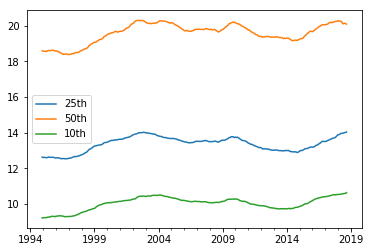

In [5]:
%matplotlib inline
wage_calc(query_str, cps_dir).plot()

In [7]:
os.chdir('/home/brian/Documents/CPS/data/')

pd.read_feather('clean/cps2018.ft').groupby('LMSTAT')['PWSSWGT'].sum()

LMSTAT
Employed - FT - government or nonprofit       235143744.0
Employed - FT - private goods producing       390351456.0
Employed - FT - private services producing    428453504.0
Employed - FT - self-employed                 103714496.0
Employed - PT or unpaid                       246619408.0
NILF - Disabled/ill                           133604680.0
NILF - Discouraged                             42830320.0
NILF - Family                                 116307656.0
NILF - Other                                   20645254.0
NILF - Retired                                412595392.0
NILF - School                                 128066184.0
Unemployed                                     59044940.0
Name: PWSSWGT, dtype: float32

In [126]:
data.loc['2017-12-01']

18.55870836074247

In [27]:
dt_windows

[DatetimeIndex(['1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
                '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
                '1994-09-01', '1994-10-01', '1994-11-01', '1994-12-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['1994-02-01', '1994-03-01', '1994-04-01', '1994-05-01',
                '1994-06-01', '1994-07-01', '1994-08-01', '1994-09-01',
                '1994-10-01', '1994-11-01', '1994-12-01', '1995-01-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
                '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
                '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['1994-04-01', '1994-05-01', '1994-06-01', '1994-07-01',
                '1994-08-01', '1994-09-01', '1994-10-01', '1994-11-01',
                '1994-12-01', '1995-01-01', '1995-02